<div class="alert alert-warning">
    
<b>Disclaimer:</b> 
    
The main objective of the <i>Jupyter</i> notebooks in this folder is to show how to use the models of the <i>QENS library</i> by


- building a fitting model: composition of models, convolution with a resolution function  
- setting and running the fit  
- extracting and displaying information about the results  

These steps have a minimizer-dependent syntax. That's one of the reasons why different minimizers have been used in the notebooks provided as examples.  
But, note that the initial guessed parameters might not be optimal, resulting in a poor fit of the reference data.
    
</div>

# Brownian Translational diffusion &lowast; Resolution with bumps

## Introduction

<div class="alert alert-info">
    
The objective of this notebook is to show how to use the <b>Brownian Translational diffusion</b> model to perform some 
fits using <a href="https://github.com/bumps/bumps">bumps</a> .
</div>

The **reference data** were generated data corresponding to a Brownian Translational diffusion model with self-diffusion coefficient = 0.145 &#x212B;$^2\times$meV.

The model was convoluted with a Gaussian resolution function 
of FWHM = 0.1 meV, centered randomly in the range \[-0.01, +0.01\] meV.

Finally the data are sampled randomly from a Poisson distribution.

The data do not have a background.

### Physical units

For information about unit conversion, please refer to the jupyter notebook called `Convert_units.ipynb` in the `tools` folder.

The dictionary of units defined in the cell below specify the units of the refined parameters adapted to the convention used in the experimental datafile.

In [1]:
# Units of parameters for selected QENS model and experimental data
dict_physical_units = {'D': "meV.Angstrom^2", 
                       'scale': "unit_of_signal.meV", 
                       'center': "meV"}

## Import the required libraries

In [2]:
from __future__ import print_function

# for interactivity (plots, buttons...)
import ipywidgets

import numpy as np

import h5py
import QENSmodels
from scipy.integrate import simps
import bumps.names as bmp
from bumps.fitters import fit
from bumps.formatnum import format_uncertainty_pm

## Setting of fitting

### Load reference data

In [3]:
path_to_data = './data/'

# Read the sample
with h5py.File(path_to_data + 'BrownianDiff_Sample.hdf', 'r') as f:
    hw = f['entry1']['data1']['X'][:]
    q = f['entry1']['data1']['Y'][:]
    unit_w=f['entry1']['data1']['X'].attrs['long_name']
    unit_q=f['entry1']['data1']['Y'].attrs['long_name']
    sqw = np.transpose(f['entry1']['data1']['DATA'][:])
    err = np.transpose(f['entry1']['data1']['errors'][:])

# Read resolution
with h5py.File(path_to_data + 'BrownianDiff_Resol.hdf', 'r') as f:
    res = np.transpose(f['entry1']['data1']['DATA'][:])

# Force resolution function to have unit area
for i in range(len(q)):
    area = simps(res[:,i], hw)
    res[:,i] /= area   

### Display units of input data
Just for information in order to determine if a conversion of units is required before using the QENSmodels

In [4]:
print(f"The names and units of `w` (`x`axis) and `q` are: {unit_w[0].decode()} and {unit_q[0].decode()}, respectively.")

The names and units of `w` (`x`axis) and `q` are: X and Y, respectively.


### Create fitting model

In [5]:
# Fitting model 
def model_convol(x, q, scale=1, center=0, D=1, resolution=None):
    model = QENSmodels.sqwBrownianTranslationalDiffusion(x, q, scale, center, D)
    return np.convolve(model, resolution/resolution.sum(), mode='same')

# Fit
Model = []

for i in range(len(q)):
    # Bumps fitting model
    Modelq = bmp.Curve(model_convol, hw, sqw[:,i], err[:,i], q=q[i], 
                       scale=1000, center=0.0, D=0.1, resolution=res[:, i])
    Modelq.scale.range(0, 1e5)
    Modelq.center.range(-0.1, 0.1)
    Modelq.D.range(0,1)
    
    # Q-independent parameters
    if i == 0:
        QD = Modelq.D  
    else:
        Modelq.D = QD
    Model.append(Modelq)
        
problem = bmp.FitProblem(Model)

In [6]:
problem.summarize()

'                                       D |.........        0.1 in (0,1)\n                                  center ....|.....          0 in (-0.1,0.1)\n                                   scale |.........       1000 in (0,100000)\n                                  center ....|.....          0 in (-0.1,0.1)\n                                   scale |.........       1000 in (0,100000)\n                                  center ....|.....          0 in (-0.1,0.1)\n                                   scale |.........       1000 in (0,100000)\n                                  center ....|.....          0 in (-0.1,0.1)\n                                   scale |.........       1000 in (0,100000)\n                                  center ....|.....          0 in (-0.1,0.1)\n                                   scale |.........       1000 in (0,100000)\n                                  center ....|.....          0 in (-0.1,0.1)\n                                   scale |.........       1000 in (0

###  Choice of minimizer for bumps

In [7]:
options_dict={'Levenberg-Marquardt': "lm", 
             'Nelder-Mead Simplex': "amoeba", 
             'DREAM': "dream", 
             'Differential Evolution': "de", 
             'Quasi-Newton BFGS': "newton", 
             'Random Lines (experimental)': "rl", 
             'Particle Swarm (experimental)': "ps", 
             'Parallel Tempering (experimental)': "pt"}

w_choice_minimizer = ipywidgets.Dropdown(
    options=list(options_dict.keys()),
    value='Levenberg-Marquardt',
    description='Minimizer:',
    layout=ipywidgets.Layout(height='40px'))

w_choice_minimizer

Dropdown(description='Minimizer:', layout=Layout(height='40px'), options=('Levenberg-Marquardt', 'Nelder-Mead …

### Setting for running bumps

In [8]:
steps_fitting = ipywidgets.IntText(
    value=100,
    description='Number of steps when fitting',
    style={'description_width': 'initial'})

steps_fitting

IntText(value=100, description='Number of steps when fitting', style=DescriptionStyle(description_width='initi…

Initial chisq 429.0449(59)


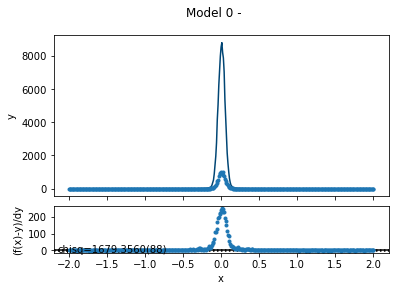

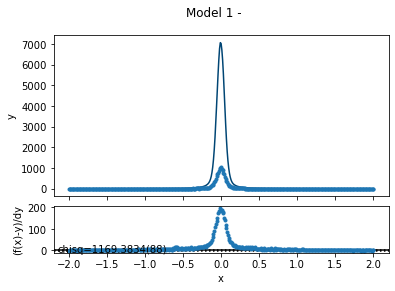

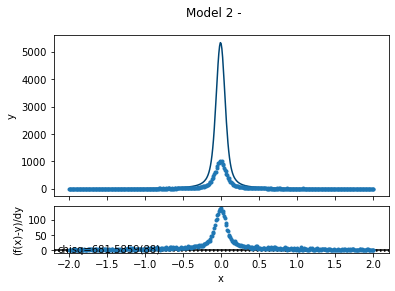

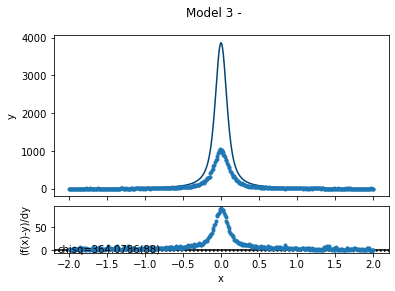

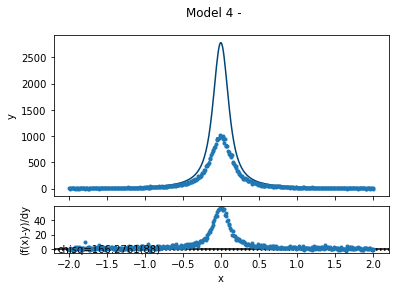

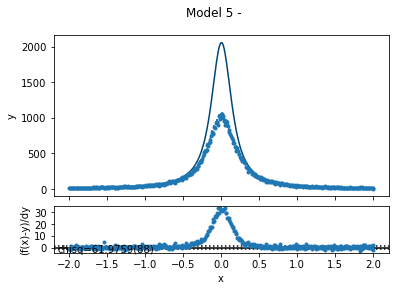

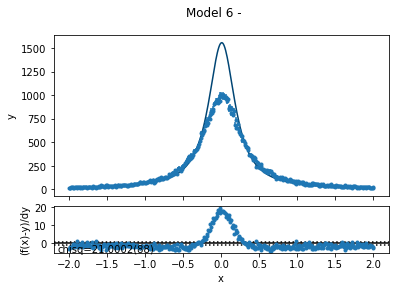

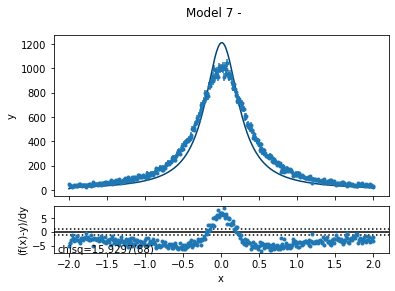

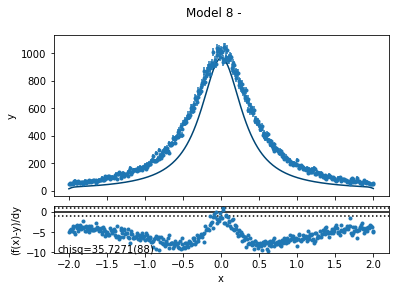

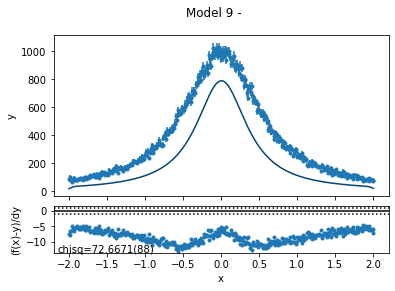

In [9]:
# Preview of the settings
print('Initial chisq', problem.chisq_str())

problem.plot()

## Running the fit

Run the fit using the *minimizer* defined above with a number of *steps* also specified above

In [10]:
result = fit(problem, 
             method=options_dict[w_choice_minimizer.value], 
             steps=int(steps_fitting.value))

## Showing the results

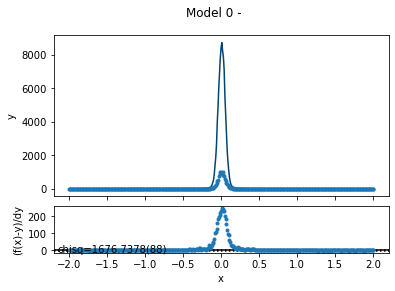

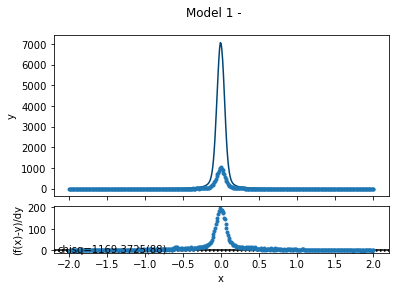

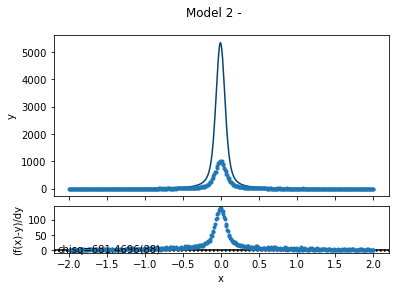

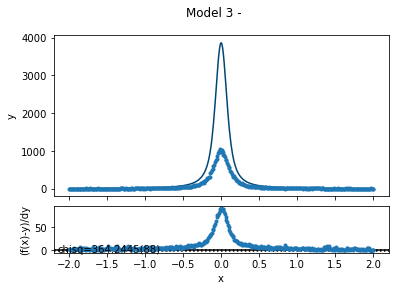

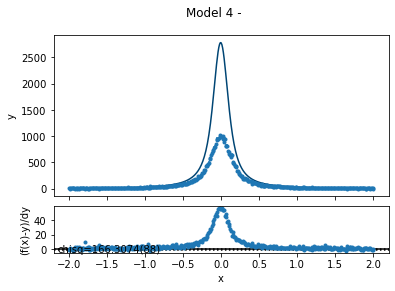

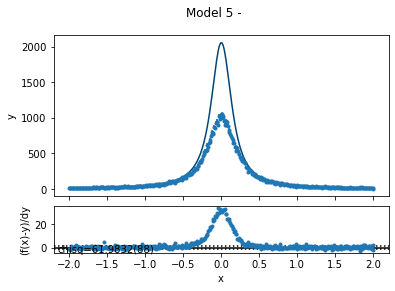

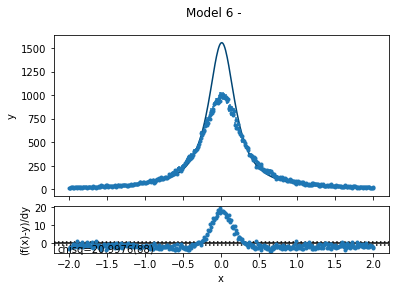

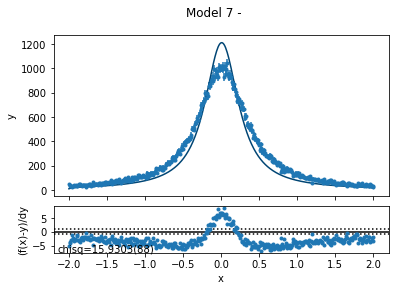

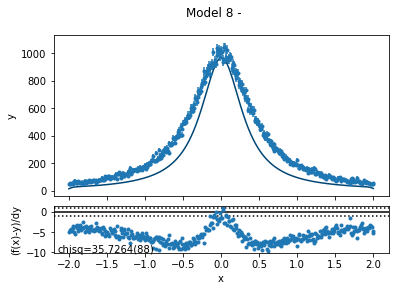

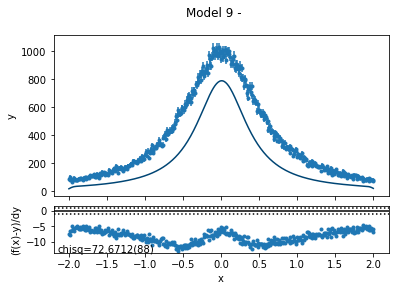

In [11]:
problem.plot()

In [12]:
# Print chi**2 and parameters' values after fit
print("final chisq", problem.chisq_str())
for k, v, dv in zip(problem.labels(), result.x, result.dx):
    if k in dict_physical_units.keys():
        print(k, ":", format_uncertainty_pm(v, dv), dict_physical_units[k])
    else:
        print(k, ":", format_uncertainty_pm(v, dv))

final chisq 428.7896(59)
D : 0.10000 +/- 0.00014 meV.Angstrom^2
center : 0.001874 +/- 0.000048 meV
scale : 1000.0 +/- 1.1 unit_of_signal.meV
center : 173e-6 +/- 80e-6 meV
scale : 1000.0 +/- 1.2 unit_of_signal.meV
center : -0.00150 +/- 0.00012 meV
scale : 1000.0 +/- 1.5 unit_of_signal.meV
center : 0.00126 +/- 0.00021 meV
scale : 1000.0 +/- 1.8 unit_of_signal.meV
center : -0.00190 +/- 0.00034 meV
scale : 1000.0 +/- 2.2 unit_of_signal.meV
center : -0.00164 +/- 0.00054 meV
scale : 1000.0 +/- 2.6 unit_of_signal.meV
center : -0.36e-3 +/- 0.72e-3 meV
scale : 1000.0 +/- 3.0 unit_of_signal.meV
center : -1.4e-3 +/- 1.3e-3 meV
scale : 1000.0 +/- 3.4 unit_of_signal.meV
center : 1.1e-3 +/- 1.7e-3 meV
scale : 1000.0 +/- 3.9 unit_of_signal.meV
center : 3.4e-3 +/- 2.4e-3 meV
scale : 1000.0 +/- 4.3 unit_of_signal.meV
